# Import Statements

In [1]:
!pip list

Package                       Version     Editable project location
----------------------------- ----------- ---------------------------------------------------
absl-py                       1.4.0
albumentations                1.3.1
apache-beam                   2.46.0
astunparse                    1.6.3
Augmentor                     0.2.12
avro-python3                  1.10.2
backcall                      0.2.0
bleach                        6.0.0
cachetools                    5.5.0
certifi                       2024.12.14
charset-normalizer            3.4.1
click                         8.1.8
cloudpickle                   2.2.1
colorama                      0.4.6
contextlib2                   21.6.0
crcmod                        1.7
cycler                        0.11.0
Cython                        3.0.11
debugpy                       1.7.0
decorator                     5.1.1
dill                          0.3.1.1
dm-tree                       0.1.8
docopt                        0.6.2

In [ ]:
!pip install wget

In [3]:
import os
import wget
import object_detection
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from PIL import Image
from random import randint
from math import log
from object_detection.utils import ops as utils_ops
import imgaug as ia

# Define Labelmap

In [3]:
with open('Tensorflow\\workspace\\annotations\\label_map.pbtxt', 'w') as f:
    f.write('item {\n')
    f.write('\tname:\'Barnacle\'\n')
    f.write('\tid:1\n')
    f.write('}\n')

# Create TF Records

In [4]:
!python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/images/train -l Tensorflow/workspace/annotations/label_map.pbtxt -o Tensorflow/workspace/annotations/train.record
!python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/images/test -l Tensorflow/workspace/annotations/label_map.pbtxt -o Tensorflow/workspace/annotations/test.record
#From the TensorflowObjectDetection Tutorial
#https://github.com/sglvladi/TensorFlowObjectDetectionTutorial/blob/master/docs/source/scripts/generate_tfrecord.py

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


In [ ]:
#Here I copied the pipeline file to my custom model path for easier access and to avoid getting it confused
#copy Tensorflow/workspace/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config Tensorflow/workspace/models/my_ssd/
#OR cp if you have Git

# Modify Pipeline File

In [5]:
config = config_util.get_configs_from_pipeline_file('Tensorflow/workspace/models/my_ssd/pipeline.config')

In [6]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile('Tensorflow/workspace/models/my_ssd/pipeline.config', "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)


In [8]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 8
pipeline_config.train_config.fine_tune_checkpoint = 'Tensorflow/workspace/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0' 
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = 'Tensorflow/workspace/annotations/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = ['Tensorflow/workspace/annotations/train.record']
pipeline_config.eval_input_reader[0].label_map_path = 'Tensorflow/workspace/annotations/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['Tensorflow/workspace/annotations/test.record']
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.max_detections_per_class = 1000
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.max_total_detections = 1000
pipeline_config.train_config.max_number_of_boxes = 1000


In [9]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile('Tensorflow/workspace/models/my_ssd/pipeline.config', "wb") as f:
    f.write(config_text)


# Train the Model

In [10]:
print("python {} --model_dir={} --pipeline_config_path={} --num_train_steps=20000".format('Tensorflow/models/research/object_detection/model_main_tf2.py', 'Tensorflow/workspace/models/my_ssd', 'Tensorflow/workspace/models/my_ssd/pipeline.config'))
#Run in command prompt

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd --pipeline_config_path=Tensorflow/workspace/models/my_ssd/pipeline.config --num_train_steps=20000


In [4]:
configs = config_util.get_configs_from_pipeline_file('Tensorflow/workspace/models/my_ssd/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('Tensorflow/workspace/models/my_ssd/ckpt-21').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

print(configs['model'])


ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 320
      width: 320
    }
  }
  feature_extractor {
    type: "ssd_mobilenet_v2_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        random_normal_initializer {
          mean: 0.0
          stddev: 0.009999999776482582
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    use_depthwise: true
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
      additional_layer_depth: 128
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
  

# Test the Results

In [5]:
category_index = label_map_util.create_category_index_from_labelmap('Tensorflow/workspace/annotations/label_map.pbtxt')
IMAGE_PATH = 'Tensorflow/workspace/images/test/aug_2_cropped1_4.jpg'
tf.config.run_functions_eagerly(True)

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bous = []
    for obj in root.findall('object'):
        bx = obj.find('bndbox')
        xmin = int(bx.find('xmin').text)
        ymin = int(bx.find('ymin').text)
        xmax = int(bx.find('xmax').text)
        ymax = int(bx.find('ymax').text)
        bous.append((xmin, ymin, xmax, ymax))
    return bous

def draw_bounding_boxes(image, boxes):
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return image

def detect_objects(image_path):
    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.20,
        agnostic_mode=False,
        skip_labels=True,
        skip_scores=True
    )
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()
    
def num_objects(image_path):
    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.20,
        agnostic_mode=False,
        skip_labels=True,
        skip_scores=True
    )
    num_detections_above_threshold = sum(detections['detection_scores'] > 0.21)
    return num_detections_above_threshold


def detect_objects_reduced(image_path):
    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Extract boxes and scores
    boxes = detections['detection_boxes']
    scores = detections['detection_scores']

    selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=200, iou_threshold=0.4, score_threshold=0.21)
    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()
    selected_classes = tf.gather(detections['detection_classes'], selected_indices).numpy()

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        selected_boxes,
        selected_classes + label_id_offset,
        selected_scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.20,
        agnostic_mode=False,
        skip_labels=True,
        skip_scores=True
    )
    num_detections_above_threshold = sum(detections['detection_scores'] > 0.21)
    print(len(selected_indices))
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()


In [89]:
%matplotlib inline

173


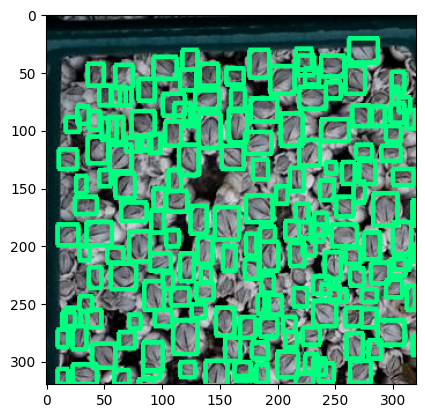

In [90]:
detect_objects_reduced('Tensorflow/workspace/images/test/aug_1_cropped_0.jpg')

Actual


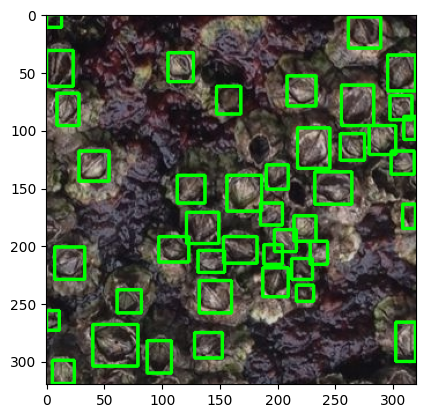

Predicted
32


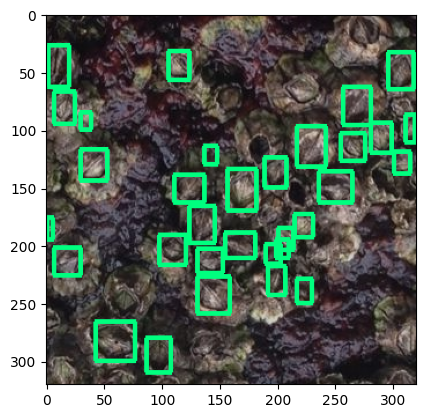

In [91]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
print("Actual")
image_path = "Tensorflow/workspace/images/test/aug_2_cropped1_4.jpg"
xml_path = "Tensorflow/workspace/images/test/aug_2_cropped1_4.xml"
image = cv2.imread(image_path)
boxes = parse_xml(xml_path)
image_with_boxes = draw_bounding_boxes(image, boxes)
image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()
print("Predicted")
detect_objects_reduced('Tensorflow/workspace/images/test/aug_2_cropped1_4.jpg')


137


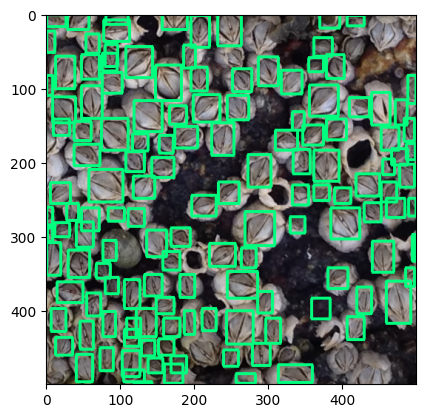

In [92]:
detect_objects_reduced('Tensorflow/workspace/images/unseen_img2.png')

118


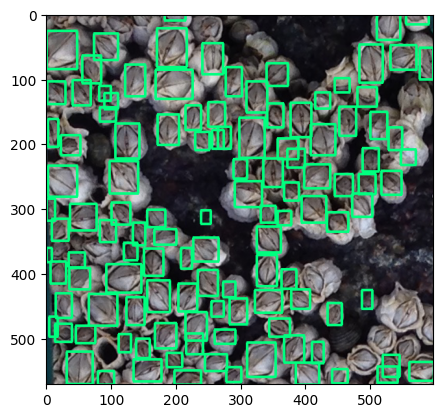

In [93]:
detect_objects_reduced('Tensorflow/workspace/images/unseen_img1_1.png')
# Image Sample taken from the upper left corner of the sample inside the turquoise frame

# Quantization Experiment using K-Means

In [98]:
def distance(a, b):
    diff_r = abs((a[0] - b[0]) ** 2)
    diff_g = abs((a[1] - b[1]) ** 2)
    diff_b = abs((a[2] - b[2]) ** 2)
    return diff_r + diff_g + diff_b

def Kmeans_quantization(image_path, output_path, K=27):
    img = Image.open(image_path)

    width = img.size[0]
    height = img.size[1]
    print(width, height)
    generations = 0

    unique_colors = set()
    pixel_data = img.load()
    categories = []
    all_pixel_values = []
    
    for x in range(width):
        for y in range(height):
            color_tuple = pixel_data[x, y]
            unique_colors.add(color_tuple)
            color_float = (float(color_tuple[0]), float(color_tuple[1]), float(color_tuple[2]))
            all_pixel_values.append(color_float) 
    unique_colors = list(unique_colors)

    selected_colors = set()
    initial_centroids = set()
    
    while len(initial_centroids) != K:
        random_index = randint(0, len(all_pixel_values) - 1)
        if all_pixel_values[random_index] in selected_colors:
            continue
        else:
            initial_centroids.add(random_index)
            selected_colors.add(all_pixel_values[random_index])
    initial_centroids = list(selected_colors)

    for i in range(len(all_pixel_values)):
        pixel_value = all_pixel_values[i] 
        all_pixel_values[i] = ((pixel_value[0], pixel_value[1], pixel_value[2]), i // height, i % height)

    previous_centroids = [((0, 0, 0), 0, 0)] * K
    iteration_count = 0

    color_count_dict = {color: 0 for color in unique_colors}
    for pixel_value in all_pixel_values:
        color_count_dict[pixel_value[0]] += 1

    while True:
        print("Generation", generations)
        color_groups = [[] for _ in range(K)]
        
        for i in range(len(unique_colors)):
            min_distance = float('inf')
            closest_centroid_index = 0
            
            for j in range(K):
                distance_value = distance(unique_colors[i], initial_centroids[j])
                if distance_value < min_distance:
                    min_distance = distance_value
                    closest_centroid_index = j
            
            for _ in range(color_count_dict[unique_colors[i]]):
                color_groups[closest_centroid_index].append(unique_colors[i])
        
        for i in range(K):
            if color_groups[i]:
                avg_r = sum(color[0] for color in color_groups[i]) / len(color_groups[i])
                avg_g = sum(color[1] for color in color_groups[i]) / len(color_groups[i])
                avg_b = sum(color[2] for color in color_groups[i]) / len(color_groups[i])
                initial_centroids[i] = (avg_r, avg_g, avg_b)

        unchanged_centroids_count = sum(1 for i in range(K) if initial_centroids[i] == previous_centroids[i])
        previous_centroids = initial_centroids.copy()

        if unchanged_centroids_count == K:
            break
        iteration_count += 1
        generations += 1

    color_mapping = {}
    for i in range(K):
        color = initial_centroids[i]
        rounded_color = (int(round(color[0])), int(round(color[1])), int(round(color[2])))
        color_mapping[i] = rounded_color

    for i in range(len(all_pixel_values)):
        min_distance = float('inf')
        closest_centroid_index = 0
        
        for j in range(K):
            distance_value = distance(all_pixel_values[i][0], initial_centroids[j])
            if distance_value < min_distance:
                min_distance = distance_value
                closest_centroid_index = j
        
        pixel_data[int(all_pixel_values[i][1]), int(all_pixel_values[i][2])] = color_mapping[closest_centroid_index]
    
    img.save(output_path)

Kmeans_quantization("Tensorflow/workspace/images/unseen_img1_1.jpg", "Tensorflow/workspace/images/unseen_img1_1_color27.png")


598 571
Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49
Generation 50
Generation 51
Generation 52
Generation 53
Generation 54
Generation 55
Generation 56
Generation 57
Generation 58
Generation 59
Generation 60
Generation 61
Generation 62
Generation 63
Generation 64
Generation 65
Generation 66
Generation 67
Generation 68
Generation 69
Generation 70
Generati

130


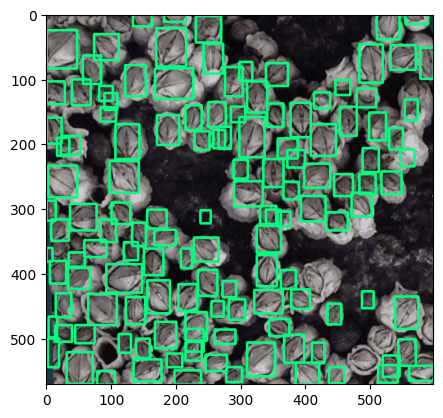

In [67]:
detect_objects_reduced('Tensorflow/workspace/images/unseen_img1_1_color27.png')

# Evaluation

Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.687

Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.713

Calculated after my model's training finished by the default evaluation script.

Given that this was done using the mobilenet model, built to run on mobile phones, and IoU is from 0.5 to 0.95 when my threshold value is 0.21 for best results (such that IoU=0.2:0.95 would give more accurate results, but cutstom IoU metrics is incompatible with the Tensorflow version I am using), the model gives somewhat accurate positive predictions and idntifies somewhat 

Now onto the more interesting, relevant metric:


In [7]:
def detect_objects(image_path):
    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    return detections['detection_boxes'], detections['detection_scores']

def calculate_mape(predicted_counts, actual_counts):
    percentage_errors = []
    for i in range(len(predicted_counts)):
        predicted = predicted_counts[i]
        actual = actual_counts[i]
        if actual != 0: 
            percentage_error = abs((predicted - actual) / actual) * 100
            percentage_errors.append(percentage_error)
    mape = sum(percentage_errors) / len(percentage_errors)
    return mape

def evaluate_predictions(folder_path, score_threshold=0.128):
    image_paths = []
    for f in os.listdir(folder_path):
        if f.endswith('.jpg'):
            image_paths.append(os.path.join(folder_path, f))
    xml_paths = []
    for image_path in image_paths:
        xml_path = os.path.splitext(image_path)[0] + '.xml'
        xml_paths.append(xml_path)

    predicted = []
    actual = []
    for image_path, xml_path in zip(image_paths, xml_paths):
        pbb, ps = detect_objects(image_path)
        tbb = parse_xml(xml_path)
        fbb = [b for b, s in zip(pbb, ps) if s >= score_threshold]
        predicted.append(len(fbb))
        actual.append(len(tbb))
    mape = calculate_mape(predicted, actual)
    return mape


folder_path = 'Tensorflow/workspace/images/test'
mape = evaluate_predictions(folder_path)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Absolute Percentage Error (MAPE): 21.790573037649686


# Next Steps

The model could potentially be improved by training on quantized segmented images, as I noticed it seems to increase accuracy slightly when used on images before running them through the model.